In [ ]:
import os
import pandas as pd
import numpy as np

Google Drive directory: /content/drive/MyDrive/AIRI/Datasets


In [22]:
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class TimeSeriesBlockBootstrap:
    def __init__(self, returns: np.ndarray, block_size: int = 10, seasonal_period: int = 252):
        self.returns = returns
        self.block_size = block_size
        self.seasonal_period = seasonal_period
        self.prices = np.exp(np.cumsum(returns))
        self.original_prices = self.prices / self.prices[0]
        self._decompose()

    def _decompose(self):
        stl = STL(self.prices,
                  period=self.seasonal_period,
                  robust=True)
        result = stl.fit()

        self.trend = result.trend
        self.seasonal = result.seasonal
        self.remainder = result.resid

    def _generate_blocks(self, n_samples: int) -> np.ndarray:
        n_blocks = int(np.ceil(n_samples / self.block_size))
        max_start = len(self.remainder) - self.block_size
        start_points = np.random.randint(0, max_start, size=n_blocks)
        blocks = [self.remainder[start:start + self.block_size]
                 for start in start_points]
        return np.concatenate(blocks)[:n_samples]

    def generate_sample(self) -> np.ndarray:
        new_remainder = self._generate_blocks(len(self.returns))
        new_prices = self.trend + self.seasonal + new_remainder
        new_returns = np.diff(np.log(new_prices))
        return np.concatenate(([0], new_returns))

    def generate_samples(self, n_samples: int = 100) -> np.ndarray:
        samples = np.zeros((n_samples, len(self.returns)))
        for i in range(n_samples):
            samples[i] = self.generate_sample()
        return samples

    def plot_bootstrap_analysis(self, n_samples: int = 100, n_paths: int = 20,
                              confidence_level: float = 0.90):
        samples = self.generate_samples(n_samples)
        price_paths = np.exp(np.cumsum(samples, axis=1))

        price_paths = price_paths / price_paths[:, 0:1]

        mean_path = np.mean(price_paths, axis=0)
        lower = np.percentile(price_paths, ((1 - confidence_level) / 2) * 100, axis=0)
        upper = np.percentile(price_paths, (1 - (1 - confidence_level) / 2) * 100, axis=0)

        plt.figure(figsize=(12, 6))

        plt.grid(True, linestyle=':', alpha=0.6)

        plt.fill_between(range(len(self.returns)), lower, upper,
                        color='gray', alpha=0.2,
                        label=f'{int(confidence_level*100)}% Confidence Interval')

        for i in range(min(n_paths, n_samples)):
            plt.plot(price_paths[i], color='blue', alpha=0.2, linewidth=0.5)

        plt.plot(self.original_prices, color='green', linewidth=1.5,
                label='Original Path')

        plt.plot(mean_path, color='red', linestyle='--', linewidth=1.5,
                label='Mean Path')

        plt.title('Bootstrapped Price Paths Based on Historical Data')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend(loc='upper right')

        buffer = 0.05
        y_min = min(lower.min(), self.original_prices.min())
        y_max = max(upper.max(), self.original_prices.max())
        plt.ylim(y_min - buffer * (y_max - y_min),
                y_max + buffer * (y_max - y_min))

        plt.tight_layout()
        plt.show()

In [23]:
sp = pd.read_csv('data/sp500_returns.csv')

In [24]:
sp

,Date,MOH,UAL,GOOG,AKAM,AES,MMM,FAST,MCO,MET,...,BIIB,ROP,ALL,TXT,PODD,ECL,LVS,EPAM,AIZ,TT
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,NaN,NaN,NaN,-0.068437,-0.040654,-0.040378,-0.056089,-0.028676,NaN,...,-0.069959,-0.046583,-0.032478,-0.016896,NaN,-0.026745,NaN,NaN,NaN,-0.020352
2,2000-01-05,NaN,NaN,NaN,-0.056570,0.010838,0.028127,0.043894,-0.018349,NaN,...,0.067381,-0.013218,0.043331,-0.024072,NaN,0.038093,NaN,NaN,NaN,-0.000935
3,2000-01-06,NaN,NaN,NaN,-0.182872,0.007846,0.077551,0.000000,0.000000,NaN,...,0.043554,0.000000,-0.005412,-0.012809,NaN,0.043470,NaN,NaN,NaN,0.052836
4,2000-01-07,NaN,NaN,NaN,0.050620,0.019149,0.019765,-0.006154,0.024391,NaN,...,0.108752,0.014599,0.036534,0.024019,NaN,0.000000,NaN,NaN,NaN,0.045955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2024-10-25,0.006008,0.001743,0.014841,-0.008107,-0.001191,-0.013686,0.008208,-0.008906,-0.023553,...,-0.011873,-0.000184,-0.020415,0.010498,-0.016976,-0.011180,0.005343,0.002824,-0.015317,0.000000
6244,2024-10-28,-0.032278,0.019240,0.008052,0.008593,0.005349,0.043446,0.010753,-0.001427,0.008398,...,0.018108,0.005758,0.005777,0.011110,-0.001113,0.011609,0.016233,-0.001202,0.012746,0.000484
6245,2024-10-29,0.024847,0.010979,0.016496,0.001069,-0.031309,-0.007824,0.012186,-0.003555,-0.003035,...,-0.008359,0.006728,-0.014051,-0.018178,-0.004294,-0.010545,-0.004316,0.013449,-0.003507,-0.005540
6246,2024-10-30,0.003275,0.044367,0.028797,-0.010839,-0.006135,-0.013308,0.009362,-0.003350,0.004125,...,-0.012560,-0.002883,0.015266,0.003540,-0.007733,-0.004582,-0.008687,-0.024911,0.007823,-0.039347


In [29]:
returns = sp['MMM'].values[1000:1750]

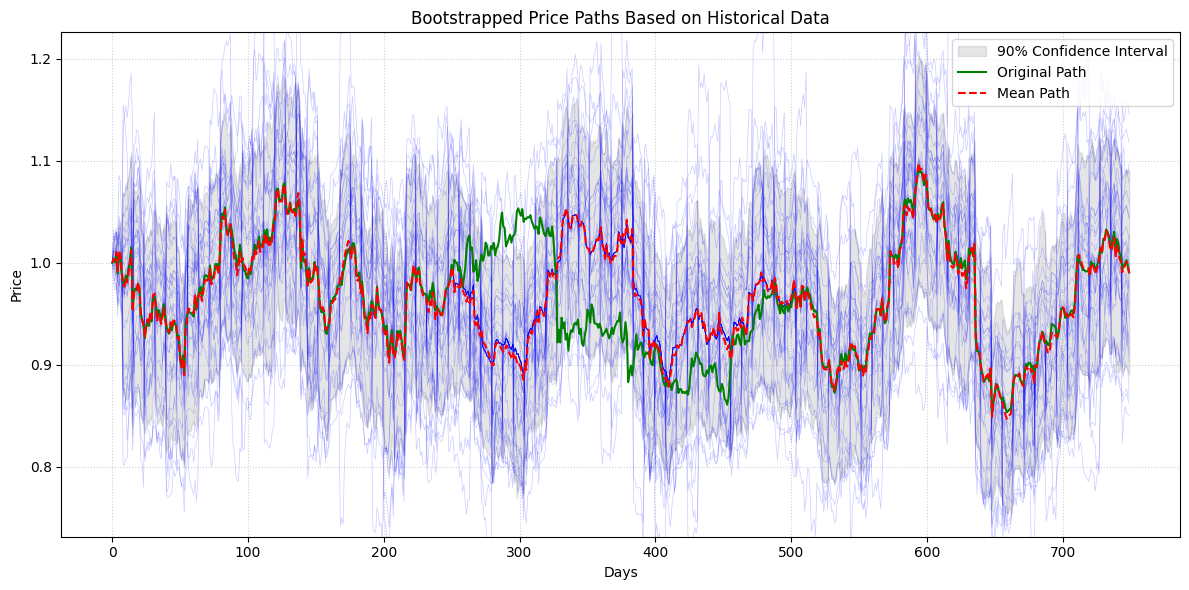

In [33]:
tsb = TimeSeriesBlockBootstrap(returns, block_size=8)
tsb.plot_bootstrap_analysis(n_samples=150, n_paths=50)